Data processing.

Data from https://zenodo.org/record/2348892/files/

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import io
import json
import mne

import joblib
import re

from scipy.io import loadmat
from scipy.signal import welch

from pyriemann.embedding import SpectralEmbedding
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasClassifier

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [3]:
file_path = r'C:\Users\brian\OneDrive - University of Tennessee\Desktop\Research\Python program\RTI-simulator\data_files'
files = [x for x in os.listdir(file_path) if re.search('.mat',x)]
print(files)

['subject_00.mat', 'subject_01.mat', 'subject_02.mat', 'subject_03.mat', 'subject_04.mat', 'subject_05.mat', 'subject_06.mat', 'subject_08.mat', 'subject_09.mat', 'subject_10.mat', 'subject_11.mat', 'subject_12.mat', 'subject_13.mat', 'subject_14.mat', 'subject_15.mat', 'subject_16.mat', 'subject_17.mat', 'subject_18.mat', 'subject_19.mat', 'subject_20.mat']


In [4]:
len(files)

20

In [5]:
# a function to extract data from a single file
def get_data(file):
    file_path = r'C:\Users\brian\OneDrive - University of Tennessee\Desktop\Research\Python program\RTI-simulator\data_files\\'
    data = loadmat(file_path + file)
    print(data)

    S = data['SIGNAL'][:, 1:17]
    stim_close = data['SIGNAL'][:, 17]
    stim_open = data['SIGNAL'][:, 18]
    stim = 1 * stim_close + 2 * stim_open

    chnames = [
        'Fp1',
        'Fp2',
        'Fc5',
        'Fz',
        'Fc6',
        'T7',
        'Cz',
        'T8',
        'P7',
        'P3',
        'Pz',
        'P4',
        'P8',
        'O1',
        'Oz',
        'O2',
        'stim']
    chtypes = ['eeg'] * 16 + ['stim']
    X = np.concatenate([S, stim[:, None]], axis=1).T

    info = mne.create_info(ch_names=chnames, sfreq=512,
                           ch_types=chtypes,
                           verbose=False)
    raw = mne.io.RawArray(data=X, info=info, verbose=False)
    

    # return the article as a dictionary to identify the article by the id.
    # The key format is 'articleID#'  --->> # represents integer numbers
    return raw

In [6]:
files

['subject_00.mat',
 'subject_01.mat',
 'subject_02.mat',
 'subject_03.mat',
 'subject_04.mat',
 'subject_05.mat',
 'subject_06.mat',
 'subject_08.mat',
 'subject_09.mat',
 'subject_10.mat',
 'subject_11.mat',
 'subject_12.mat',
 'subject_13.mat',
 'subject_14.mat',
 'subject_15.mat',
 'subject_16.mat',
 'subject_17.mat',
 'subject_18.mat',
 'subject_19.mat',
 'subject_20.mat']

In [7]:
raw = get_data(files[0])

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec 13 21:47:47 2018', '__version__': '1.0', '__globals__': [], 'SIGNAL': array([[ 0.00000000e+00,  2.31471094e+03, -2.47386426e+03, ...,
        -3.27888818e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.95312500e-03,  2.31207739e+03, -2.47719287e+03, ...,
        -3.27667456e+03,  0.00000000e+00,  0.00000000e+00],
       [ 3.90625000e-03,  2.30813916e+03, -2.47775000e+03, ...,
        -3.26313354e+03,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.23244141e+02,  1.92760596e+03, -2.45507520e+03, ...,
        -3.27909985e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.23246094e+02,  1.93911743e+03, -2.44151099e+03, ...,
        -3.25797363e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.23248047e+02,  1.94014917e+03, -2.43970483e+03, ...,
        -3.24809204e+03,  0.00000000e+00,  0.00000000e+00]])}


In [8]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"16 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


In [9]:
raw.describe()

<RawArray | 17 x 63104 (123.2 s), ~8.2 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  Fp1   EEG   µV    1919117919.90  2181048034.68  2275398925.80  2422695739.77  2577585205.10
 1  Fp2   EEG   µV    -2557157959.00  -2456960937.47  -2362735351.55  -2231222045.88  -2104002685.50
 2  Fc5   EEG   µV    217782211.30  430085990.91  510669525.15  560539947.51  795885375.98
 3  Fz    EEG   µV    -7108479492.20  -6816313232.43  -6781700683.60  -6714244018.57  -6612576660.20
 4  Fc6   EEG   µV    -6534169433.60  -6374752075.20  -6266024902.35  -6208651123.05  -6095611328.10
 5  T7    EEG   µV    -11849524414.00  -11518110351.50  -11400988769.50  -11323991699.50  -11208399414.00
 6  Cz    EEG   µV    -2934821289.10  -2712221618.65  -2555023925.80  -2486022583.05  -2391815185.50
 7  T8    EEG   µV    -14278633789.00  -13982040039.00  -13955098633.00  -13930370361.50  -13821010742.00
 8  P7    EEG   µV    -2057885986.30  -1844913513.15  -1780144714

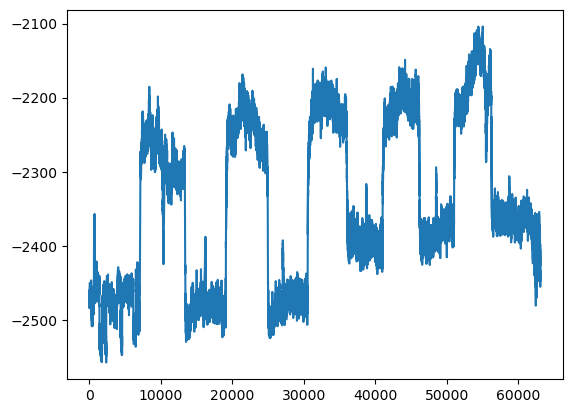

In [10]:
plt.plot(raw.get_data()[1])

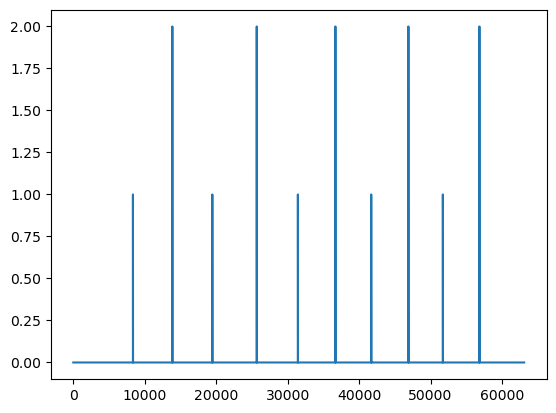

In [11]:
plt.plot(raw.get_data()[-1])

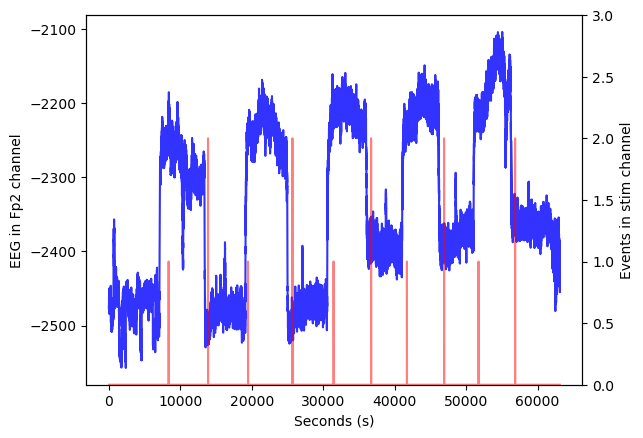

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
ax2 = ax.twinx()
ax.plot(raw.get_data()[1],c='b',alpha=0.8)
ax2.plot(raw.get_data()[-1],c='r',alpha=0.5)
ax.set_ylabel('EEG in Fp2 channel')
ax2.set_ylabel('Events in stim channel')
ax.set_xlabel('Seconds (s)')
ax2.set_ylim(0,3)
plt.show()

In [13]:
def processData(raw):
    # filter data and resample
    fmin = 3
    fmax = 40
    raw.filter(fmin, fmax, verbose=False)
    raw.resample(sfreq=128, verbose=False)

    # detect the events and cut the signal into epochs
    events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
    event_id = {'closed': 1, 'open': 2}
    epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, baseline=None,
                        verbose=False,preload=True)
    epochs.pick_types(eeg=True)
    return epochs,events
    
def PlotIt(epochs,ch):
    epochs.load_data().pick(ch)
    # estimate the averaged spectra for each condition
    X_closed = epochs['closed'].get_data(verbose=False)
    f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], axis=2)
    S_closed = np.mean(S_closed, axis=0).squeeze()
    X_opened = epochs['open'].get_data(verbose=False)
    f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], axis=2)
    S_opened = np.mean(S_opened, axis=0).squeeze()

    # plot the results
    fig = plt.figure(facecolor='white', figsize=(8, 6))
    plt.plot(f, S_closed, c='k', lw=4.0, label='closed')
    plt.plot(f, S_opened, c='r', lw=4.0, label='open')
    plt.xlim(0, 40)
    plt.xlabel('frequency', fontsize=14)
    plt.title('PSD on both conditions (averaged over 5 trials)', fontsize=16)
    plt.legend()
    plt.show()
    
    

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec 13 21:47:47 2018', '__version__': '1.0', '__globals__': [], 'SIGNAL': array([[ 0.00000000e+00,  2.31471094e+03, -2.47386426e+03, ...,
        -3.27888818e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.95312500e-03,  2.31207739e+03, -2.47719287e+03, ...,
        -3.27667456e+03,  0.00000000e+00,  0.00000000e+00],
       [ 3.90625000e-03,  2.30813916e+03, -2.47775000e+03, ...,
        -3.26313354e+03,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.23244141e+02,  1.92760596e+03, -2.45507520e+03, ...,
        -3.27909985e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.23246094e+02,  1.93911743e+03, -2.44151099e+03, ...,
        -3.25797363e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.23248047e+02,  1.94014917e+03, -2.43970483e+03, ...,
        -3.24809204e+03,  0.00000000e+00,  0.00000000e+00]])}
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


C:\Users\brian\AppData\Local\Temp\ipykernel_10608\3535682334.py:19: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_closed = epochs['closed'].get_data(verbose=False)
C:\Users\brian\Anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 91, using nperseg = 91
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
C:\Users\brian\AppData\Local\Temp\ipykernel_10608\3535682334.py:22: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_opened = epochs['open'].get_data(verbose=False)


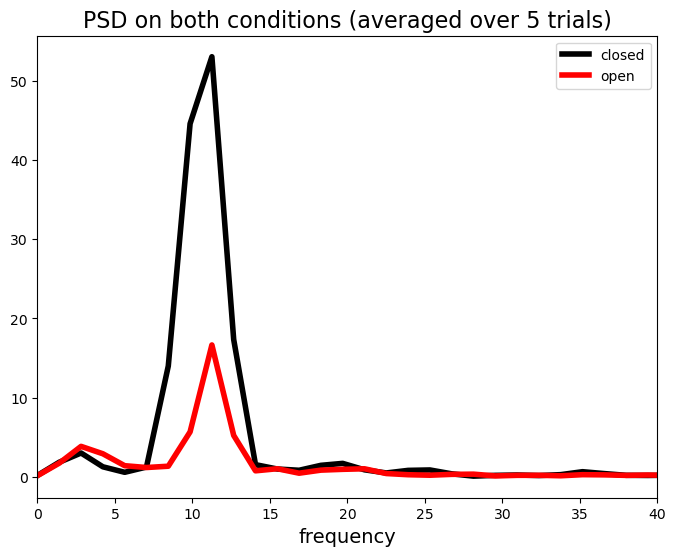

In [14]:
epochs, _ = processData(get_data(files[0]))
PlotIt(epochs,'Oz')

C:\Users\brian\AppData\Local\Temp\ipykernel_10608\4069028416.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  plt.plot(epochs.get_data()[0].ravel())


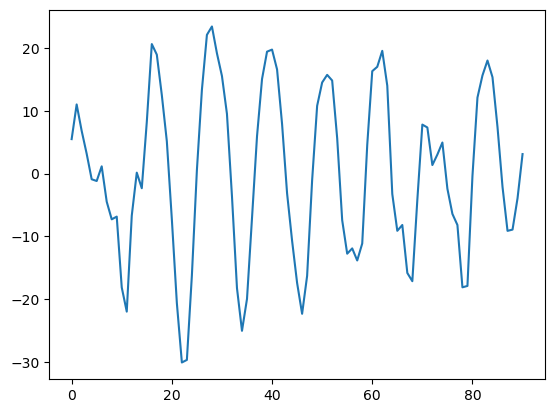

In [15]:
plt.plot(epochs.get_data()[0].ravel())

In [16]:
import warnings
warnings.filterwarnings("ignore")

raw = get_data(files[0])

# filter data and resample
fmin = 3
fmax = 40
raw.filter(fmin, fmax, verbose=False)
raw.resample(sfreq=128, verbose=False)

# detect the events and cut the signal into epochs
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.2, baseline=None,
                    verbose=False)
epochs.load_data().pick(['Oz'])

# get trials and labels
shape_x = epochs.get_data(verbose=False).shape[0]
shape_y = epochs.get_data(verbose=False).shape[2]
X = epochs.get_data().ravel().reshape((shape_x,shape_y))
y = events[:, -1]

print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

# cross validation
skf = StratifiedKFold(n_splits=5)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
scr = cross_val_score(clf, X, y, cv=skf)
preds = cross_val_predict(clf, X, y, cv=skf)

# print results of classification
print('subject', files[0])
print('mean SVC accuracy :', scr.mean())

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec 13 21:47:47 2018', '__version__': '1.0', '__globals__': [], 'SIGNAL': array([[ 0.00000000e+00,  2.31471094e+03, -2.47386426e+03, ...,
        -3.27888818e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.95312500e-03,  2.31207739e+03, -2.47719287e+03, ...,
        -3.27667456e+03,  0.00000000e+00,  0.00000000e+00],
       [ 3.90625000e-03,  2.30813916e+03, -2.47775000e+03, ...,
        -3.26313354e+03,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.23244141e+02,  1.92760596e+03, -2.45507520e+03, ...,
        -3.27909985e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.23246094e+02,  1.93911743e+03, -2.44151099e+03, ...,
        -3.25797363e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.23248047e+02,  1.94014917e+03, -2.43970483e+03, ...,
        -3.24809204e+03,  0.00000000e+00,  0.00000000e+00]])}
Using data from preloaded Raw for 10 events and 53 original time points ...
0 bad epochs droppe

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,shuffle=True)
model = SVC(gamma='auto')
SS = StandardScaler().fit(X_train)
X_train = SS.transform(X_train)
model.fit(X_train,y_train)
y_pred = model.predict(SS.transform(X_test))
print('SCV accuracy score: ', accuracy_score(y_test, y_pred))

SCV accuracy score:  1.0


In [22]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [23]:
subject = files[0]

# filter data and resample
fmin = 3
fmax = 40
raw.filter(fmin, fmax, verbose=False)
raw.resample(sfreq=128, verbose=False)

# detect the events and cut the signal into epochs
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=2.0, tmax=8.0, baseline=None,
                    verbose=False, preload=True)
epochs.pick_types(eeg=True)

# get trials and labels
X = epochs.get_data()
y = events[:, -1]

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


subject subject_00.mat
mean accuracy : 1.0


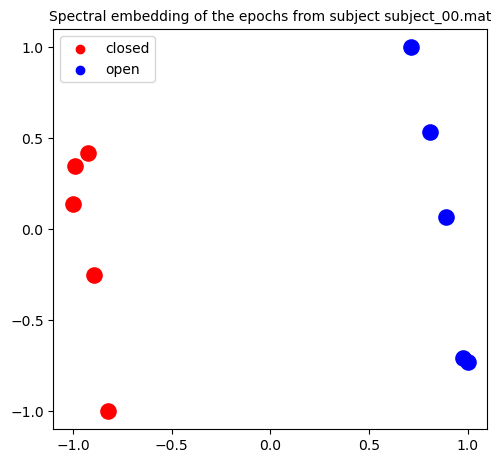

In [24]:
# cross validation
skf = StratifiedKFold(n_splits=5)
clf = make_pipeline(Covariances(estimator='lwf'), MDM())
scr = cross_val_score(clf, X, y, cv=skf)

# print results of classification
print('subject', subject)
print('mean accuracy :', scr.mean())

# get the spectral embedding of the epochs
C = Covariances(estimator='lwf').fit_transform(X)
emb = SpectralEmbedding(metric='riemann').fit_transform(C)

# scatter plot of the embedded points
fig = plt.figure(facecolor='white', figsize=(5.6, 5.2))
colors = {1: 'r', 2: 'b'}
for embi, yi in zip(emb, y):
    plt.scatter(embi[0], embi[1], s=120, c=colors[yi])
labels = {1: 'closed', 2: 'open'}
for yi in np.unique(y):
    plt.scatter([], [], c=colors[yi], label=labels[yi])
plt.xticks([-1, -0.5, 0.0, +0.5, 1.0])
plt.yticks([-1, -0.5, 0.0, +0.5, 1.0])
plt.legend()
plt.title(
    'Spectral embedding of the epochs from subject ' +
    str(subject),
    fontsize=10)

plt.show()

In [25]:
chnames = [
        'Fp1',
        'Fp2',
        'Fc5',
        'Fz',
        'Fc6',
        'T7',
        'Cz',
        'T8',
        'P7',
        'P3',
        'Pz',
        'P4',
        'P8',
        'O1',
        'Oz',
        'O2',
        'stim']

n_channels = len(chnames)
n_channels

17

In [26]:
epochs.get_data()

array([[[-13.6555626 ,  -8.43792647,   0.4327612 , ...,  -2.0590503 ,
           3.62017393,   4.05957531],
        [-10.48512907,  -7.89960328,  -1.62631367, ...,   1.7644762 ,
           7.90762893,   6.49737362],
        [-13.90599708,  -6.97197255,  -0.16718558, ...,  -8.07524231,
         -10.16628791,  -9.80080508],
        ...,
        [  0.67555152,  -9.44551574, -22.27072963, ...,  20.36382956,
          21.77589502,  15.82469824],
        [ -4.16323738, -14.96201388, -26.33704855, ...,  16.62561418,
          23.34160815,  21.40371071],
        [ -0.54926781, -13.0079802 , -27.22551531, ...,  17.9207628 ,
          25.05806864,  24.23546433]],

       [[  9.08259479,   1.42127325,  -4.74131195, ...,   8.44791783,
          17.52587207,  13.46316649],
        [  5.19883551,  -0.86217908,  -5.96154346, ...,   6.26591319,
          13.34935061,  12.38799764],
        [  6.45401865,   2.71203585,  -4.01962687, ...,   4.34449445,
          10.20105637,   6.67852865],
        ...,


In [27]:
files

['subject_00.mat',
 'subject_01.mat',
 'subject_02.mat',
 'subject_03.mat',
 'subject_04.mat',
 'subject_05.mat',
 'subject_06.mat',
 'subject_08.mat',
 'subject_09.mat',
 'subject_10.mat',
 'subject_11.mat',
 'subject_12.mat',
 'subject_13.mat',
 'subject_14.mat',
 'subject_15.mat',
 'subject_16.mat',
 'subject_17.mat',
 'subject_18.mat',
 'subject_19.mat',
 'subject_20.mat']

In [28]:
events.shape

(10, 3)

In [29]:
np.array(chnames).shape

(17,)

In [30]:
X = []
y = []
for file in files:
    data = get_data(file)
    processed,events = processData(data)
    for processed_one, event in zip(processed,events):
        X.append(processed_one)
        y.append(event[-1])

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec 13 21:47:47 2018', '__version__': '1.0', '__globals__': [], 'SIGNAL': array([[ 0.00000000e+00,  2.31471094e+03, -2.47386426e+03, ...,
        -3.27888818e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.95312500e-03,  2.31207739e+03, -2.47719287e+03, ...,
        -3.27667456e+03,  0.00000000e+00,  0.00000000e+00],
       [ 3.90625000e-03,  2.30813916e+03, -2.47775000e+03, ...,
        -3.26313354e+03,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.23244141e+02,  1.92760596e+03, -2.45507520e+03, ...,
        -3.27909985e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.23246094e+02,  1.93911743e+03, -2.44151099e+03, ...,
        -3.25797363e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.23248047e+02,  1.94014917e+03, -2.43970483e+03, ...,
        -3.24809204e+03,  0.00000000e+00,  0.00000000e+00]])}
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
{'__header__': b'M

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Dec 14 09:53:31 2018', '__version__': '1.0', '__globals__': [], 'SIGNAL': array([[ 0.00000000e+00, -2.01390488e+04, -9.87133984e+03, ...,
         7.71173486e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.95312500e-03, -2.01402305e+04, -9.87845508e+03, ...,
         7.70625684e+03,  0.00000000e+00,  0.00000000e+00],
       [ 3.90625000e-03, -2.01317832e+04, -9.87711328e+03, ...,
         7.70870264e+03,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.54806641e+02, -2.20300117e+04, -8.58470508e+03, ...,
         7.34203027e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.54808594e+02, -2.20374902e+04, -8.59333301e+03, ...,
         7.37336182e+03,  0.00000000e+00,  0.00000000e+00],
       [ 1.54810547e+02, -2.20344863e+04, -8.59097168e+03, ...,
         7.40634424e+03,  0.00000000e+00,  0.00000000e+00]])}
NOTE: pick_types()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Dec 14 09:36:22 2018', '__version__': '1.0', '__globals__': [], 'SIGNAL': array([[0.00000000e+00, 2.34733438e+05, 2.36993516e+05, ...,
        2.33703922e+05, 0.00000000e+00, 0.00000000e+00],
       [1.95312500e-03, 2.34741844e+05, 2.37002516e+05, ...,
        2.33717125e+05, 0.00000000e+00, 0.00000000e+00],
       [3.90625000e-03, 2.34771469e+05, 2.37035047e+05, ...,
        2.33748859e+05, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.77556641e+02, 2.34507750e+05, 2.36753484e+05, ...,
        2.33383859e+05, 0.00000000e+00, 0.00000000e+00],
       [1.77558594e+02, 2.34579906e+05, 2.36819281e+05, ...,
        2.33468031e+05, 0.00000000e+00, 0.00000000e+00],
       [1.77560547e+02, 2.34606703e+05, 2.36851562e+05, ...,
        2.33487109e+05, 0.00000000e+00, 0.00000000e+00]])}
NOTE: pick_types() is a legacy function. New code shou

In [31]:
X = np.array(X)
print('X shape: ', X.shape)
y = np.array(y)
print('y shape: ', y.shape)

X shape:  (200, 16, 91)
y shape:  (200,)


In [32]:
X_trans = Covariances(estimator='lwf').fit_transform(X,y)

In [33]:
X_trans = np.array(X_trans)
print('X shape: ', X_trans.shape)

X shape:  (200, 16, 16)


In [34]:
X_trans_picked = X_trans[:,8,:]

In [35]:
X_trans_picked.shape

(200, 16)

In [36]:
#X_trans_picked = X_trans.reshape(X_trans.shape[0],-1)

In [37]:
# cross validation
skf = StratifiedKFold(n_splits=5)
model = SVC(kernel='rbf', gamma='auto')
scr = cross_val_score(model, X_trans_picked, y, cv=skf)
preds = cross_val_predict(model, X_trans_picked, y, cv=skf)

# print results of classification
print('mean accuracy :', scr.mean())

mean accuracy : 0.53


In [38]:
X_trans_picked.shape

(200, 16)

In [39]:
len(chnames)

17

In [40]:
acc_test = {}
for i,ch in zip(range(X_trans.shape[1]),chnames):
    print('-'*100)
    print(ch)
    X_trans_picked = X_trans[:,i,:]
    # cross validation
    skf = StratifiedKFold(n_splits=5)
    svc = SVC(kernel='rbf', gamma='auto')
    scr = cross_val_score(svc, X_trans_picked, y, cv=skf)
    preds = cross_val_predict(svc, X_trans_picked, y, cv=skf)

    # print results of classification
    print('mean accuracy :', scr.mean())
    acc_test[ch] = scr.mean()
    
    grid_SVC ={'C':list(range(1,5)),
                'kernel':['linear','poly','rbf','sigmoid'],
                'degree':list(range(1,5)),
                'gamma':['auto','scale'],
                
            }
    grid_svc = GridSearchCV(svc, grid_SVC, cv=skf, scoring='accuracy')
    grid_svc.fit(X_trans_picked, y)
    print("Best parameters set found on development set:")
    print(grid_svc.best_params_)
    print()
    print("Grid best score:")
    print (grid_svc.best_score_)

----------------------------------------------------------------------------------------------------
Fp1
mean accuracy : 0.515
Best parameters set found on development set:
{'C': 3, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Grid best score:
0.8099999999999999
----------------------------------------------------------------------------------------------------
Fp2
mean accuracy : 0.52
Best parameters set found on development set:
{'C': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}

Grid best score:
0.7700000000000001
----------------------------------------------------------------------------------------------------
Fc5
mean accuracy : 0.5349999999999999
Best parameters set found on development set:
{'C': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'linear'}

Grid best score:
0.7799999999999999
----------------------------------------------------------------------------------------------------
Fz
mean accuracy : 0.5399999999999999
Best parameters set found on development set:


In [38]:
np.max(list(acc_test.values()))

0.545

In [39]:
acc_test = {}
for i,ch in zip(range(X_trans.shape[1]),chnames):
    print('-'*100)
    print(ch)
    X_trans_picked = X_trans[:,i,:]
    # cross validation
    skf = StratifiedKFold(n_splits=8)
    rf = RandomForestClassifier()
    scr = cross_val_score(rf, X_trans_picked, y, cv=skf)
    preds = cross_val_predict(rf, X_trans_picked, y, cv=skf)

    # print results of classification
    print('mean accuracy :', scr.mean())
    acc_test[ch] = scr.mean()

    grid_RF ={'max_depth':[3,5,10,None],
                'n_estimators':[100,120,140,200],
                'max_features':[1,3,5,7],
                'min_samples_leaf':[1,2,3],
                'min_samples_split':[1,2,3]}
    grid_rf = GridSearchCV(rf, grid_RF, cv=skf, scoring='accuracy')
    grid_rf.fit(X_trans_picked, y)
    print("Best parameters set found on development set:")
    print(grid_rf.best_params_)
    print()
    print("Grid best score:")
    print (grid_rf.best_score_)

----------------------------------------------------------------------------------------------------
Fp1
mean accuracy : 0.74
Best parameters set found on development set:
{'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 120}

Grid best score:
0.765
----------------------------------------------------------------------------------------------------
Fp2
mean accuracy : 0.765
Best parameters set found on development set:
{'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 140}

Grid best score:
0.79
----------------------------------------------------------------------------------------------------
Fc5
mean accuracy : 0.775
Best parameters set found on development set:
{'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Grid best score:
0.805
------------------------------------------------------------------------------------------------

In [40]:
np.max(list(acc_test.values()))

0.805

It seems like O1 channel seems to be the best for SVC (86% accuracy) and P8 channel (83.6% accuracy) for RF.

In [36]:
chnames.index('O1')

13

In [45]:
print('-'*100)
print('O1 channel')
i = chnames.index('O1')
X_trans_picked = X_trans[:,i,:]
# cross validation
skf = StratifiedKFold(n_splits=5)
svc = SVC(C=1,
          degree=1,
          gamma='auto', 
          kernel='poly')
scr = cross_val_score(svc, X_trans_picked, y, cv=skf)
preds = cross_val_predict(svc, X_trans_picked, y, cv=skf)

# print results of classification
print('mean accuracy :', scr.mean())

svc.fit(X_trans_picked, y)

----------------------------------------------------------------------------------------------------
O1 channel
mean accuracy : 0.86


SVC(C=1, degree=1, gamma='auto', kernel='poly')

In [48]:
print('-'*100)
print('P8 channel')
i = chnames.index('P8')
X_trans_picked = X_trans[:,i,:]
# cross validation
skf = StratifiedKFold(n_splits=8)
rf = RandomForestClassifier(max_depth= 10,
                            max_features= 7, 
                            min_samples_leaf= 2, 
                            min_samples_split= 3, 
                            n_estimators= 140)
scr = cross_val_score(rf, X_trans_picked, y, cv=skf)
preds = cross_val_predict(rf, X_trans_picked, y, cv=skf)

# print results of classification
print('mean accuracy :', scr.mean())


rf.fit(X_trans_picked, y)

----------------------------------------------------------------------------------------------------
P8 channel
mean accuracy : 0.8200000000000001


RandomForestClassifier(max_depth=10, max_features=7, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=140)

In [74]:
def build_LSTM(hidden=16, window=16):
    # Define the model
    LSTM_model = Sequential()
    LSTM_model.name="LSTM"
    LSTM_model.add(LSTM(hidden, input_shape=(window,window),name='LSTM_hidden1'))
    LSTM_model.add(Dense(32,name='Dense_hidden1'))
    LSTM_model.add(Dense(1,name='Output'))
    LSTM_model.compile(optimizer='adam', loss='mae')
    #LSTM_model.summary()
    return LSTM_model

LSTM_model = KerasClassifier(build_fn=build_LSTM(32,16))
LSTM_model

KerasClassifier(
	model=None
	build_fn=<Sequential name=LSTM, built=True>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [76]:
# cross validation
skf = StratifiedKFold(n_splits=5)
scr = cross_val_score(LSTM_model, X_trans, y, cv=skf)
preds = cross_val_predict(LSTM_model, X_trans, y, cv=skf)

# print results of classification
print('mean accuracy :', scr.mean())
acc_test[ch] = scr.mean()

LSTM_model.fit(X_trans,y,epochs=100,verbose=0)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1094
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0874
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0872
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1173
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1012
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1255
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1028
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0909
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1026
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1170
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
mean accuracy : 0.97


KerasClassifier(
	model=None
	build_fn=<Sequential name=LSTM, built=True>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [50]:
X_trans.shape

(200, 16, 16)

In [ ]:
LSTM_mode.predict()

In [49]:
#joblib.dump(svc,'SVC_model.pkl')

['SVC_model.pkl']

In [50]:
#joblib.dump(rf,'RF_model.pkl')

['RF_model.pkl']

In [48]:
#joblib.dump(grid_rf.best_params_,'RF_params.pkl')

['RF_params.pkl']

In [49]:
#joblib.dump(grid_rf.best_score_,'RF_score.pkl')

['RF_score.pkl']

In [77]:
#joblib.dump(LSTM_model,'LSTM_model.pkl')

['LSTM_model.pkl']